<a href="https://colab.research.google.com/github/jfjoung/AI_For_Chemistry/blob/main/Week_6_Molecule_generation_(VAE).ipynbb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🎯 학습 목표

- **분자 생성 모델(Molecular Generative Models)**의 개념과 **화학에서의 활용 사례**를 이해한다.  
- **SMILES 기반의 분자 표현 방식**과 이를 활용한 **생성 모델 학습 방법**을 학습한다.  
- **Recurrent Neural Networks (RNNs)**를 활용한 **SMILES 생성 모델**의 구조와 작동 원리를 이해한다.  
- **RNN 학습을 위한 데이터 전처리** 및 **문자열 생성 방식(greedy sampling, multinomial sampling)**의 차이를 배운다.  
- 실습을 통해 **훈련된 분자 생성 모델을 평가**하고, **생성된 분자의 유효성(validity), 고유성(novelty), 다양성(diversity)** 등의 지표를 통해 모델 성능을 해석한다.  
- **화학적으로 타당한 분자 생성**을 위한 모델 개선 방향(예: 조건부 생성, graph-based 모델 등)에 대해 간단히 고찰한다.  


In [1]:
# 사용할 유틸리티 함수들이 정의된 utils.py 파일을 다운로드
!wget https://raw.githubusercontent.com/jfjoung/AI_For_Chemistry/main/data/week6/utils.py -O utils.py

# 사전 학습된 RNN 모델 파일 다운로드
!wget https://raw.githubusercontent.com/jfjoung/AI_For_Chemistry/main/data/week6/pretrained.rnn.pth -O pretrained.rnn.pth

# 사전 학습된 VAE 모델 파일 다운로드
!wget https://raw.githubusercontent.com/jfjoung/AI_For_Chemistry/main/data/week6/pretrained.vae.pt -O pretrained.vae.pt

!git clone https://github.com/rociomer/dl-chem-101.git

# RNN 학습에 사용된 SMILES 데이터 파일 다운로드
!wget https://raw.githubusercontent.com/jfjoung/AI_For_Chemistry/main/data/week6/zinc.smi -O zinc.smi

# VAE 모델을 위한 분자 데이터셋을 포함한 저장소 복제
!git clone https://github.com/aksub99/molecular-vae.git

# 압축된 분자 데이터 파일 압축 해제
import zipfile
zip_ref = zipfile.ZipFile('molecular-vae/data/processed.zip', 'r')
zip_ref.extractall('molecular-vae/data/')
zip_ref.close()


--2025-04-04 11:47:10--  https://raw.githubusercontent.com/jfjoung/AI_For_Chemistry/main/data/week6/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2031 (2.0K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   1.98K  --.-KB/s    in 0s      

2025-04-04 11:47:10 (19.8 MB/s) - ‘utils.py’ saved [2031/2031]

--2025-04-04 11:47:11--  https://raw.githubusercontent.com/jfjoung/AI_For_Chemistry/main/data/week6/pretrained.rnn.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25454495 (24M) [app

In [2]:
# RNN 모델이 포함된 저장소 디렉토리로 이동
%cd dl-chem-101

# SMILES 생성을 위한 LSTM 코드가 있는 하위 폴더로 이동
%cd 03_gen_SMILES_LSTM

# 현재 디렉토리를 editable 모드로 패키지 설치 (코드 수정 시 즉시 반영됨)
!pip install -e .


/content/dl-chem-101
/content/dl-chem-101/03_gen_SMILES_LSTM
Obtaining file:///content/dl-chem-101/03_gen_SMILES_LSTM
  Preparing metadata (setup.py) ... done
  Attempting uninstall: smiles_lstm
    Found existing installation: smiles_lstm 1.0.0
    Uninstalling smiles_lstm-1.0.0:
      Successfully uninstalled smiles_lstm-1.0.0
  Running setup.py develop for smiles_lstm


In [3]:
!pip install rdkit
!pip install molplotly
!pip install torch==2.1
!pip install numpy==1.26
!pip install scikit-learn
!pip install h5py
!pip install dash==2.9.2
!pip install tqdm

In [4]:
# 상위 폴더(dl-chem-101의 루트 디렉토리)로 이동
%cd ../..

# 🔄 ***이제 노트북의 런타임을 반드시 재시작해야 합니다!***

# ✅ 왜 재시작해야 하나요?
# - pip으로 새 패키지를 설치하거나, 기존 패키지를 다른 버전으로 설치하면 Colab 환경에 즉시 반영되지 않습니다.
# - 특히 `pip install -e .` 같은 editable 설치는 런타임을 재시작해야 적용됩니다.
# - 또한 패키지나 모듈 경로 설정 충돌을 방지하기 위해 깨끗한 환경에서 시작하는 것이 중요합니다.

# 🔧 어떻게 재시작하나요?
# 메뉴에서 [런타임] → [세션 다시 시작] 클릭
# 또는 단축키: Ctrl+M → . (Windows) / Cmd+M → . (Mac)

# 📌 재시작 후에는 "맨 위 셀부터" 순서대로 모든 코드를 다시 실행해야 합니다.
# 설치된 패키지, 다운로드한 파일, 변수 등이 모두 초기화되었기 때문입니다.


/content


# 분자 생성 모델 (Molecular Generative Models)

최근 몇 년 사이, 다양한 **분자 생성 모델**이 활발히 개발되고 있습니다. 모델의 구현 방식은 다를 수 있지만, 대부분 다음과 같은 공통점을 가지고 있습니다:

1. 학습 데이터에 **존재하지 않는 새로운 분자**를 생성할 수 있기 때문에, **새로운 화학 공간을 탐색**할 수 있는 가능성을 가집니다.  

2. 최적화 알고리즘과 결합하여, **특정 목표를 만족하는 분자**(예: 높은 용해도를 갖는 분자)를 생성하도록 모델을 조정할 수 있습니다.

👉 다음 주에는 [`REINVENT`](https://github.com/MolecularAI/Reinvent)라는 오픈소스 SMILES 기반 분자 생성 모델을 직접 실습해볼 예정입니다.  
이 모델은 AstraZeneca에서 개발되었으며, 여러분이 직접 원하는 물성 목표를 설정하고,  
모델이 그 목표에 맞는 분자를 학습해 생성하는 과정을 체험하게 됩니다! 🤠  
예시로, 실제로 `REINVENT`를 활용해 실험적으로 검증된 **나노몰 농도의 강력한 억제제**를 설계한 연구도 있습니다:  
[논문 보기](https://chemistry-europe.onlinelibrary.wiley.com/doi/10.1002/cmdc.202000786)

---

생성 모델은 사실 새로운 개념은 아니며, 머신러닝 분야에서는 오래전부터 이미지 생성과 같은 응용에 활용되어 왔습니다.  
예를 들어, 여러분이 자주 보는 멋진 생성 이미지들은 [Stable Diffusion](https://huggingface.co/spaces/stabilityai/stable-diffusion)과 같은 모델에서 비롯된 것입니다.  
하지만 **분자 생성 모델**은 비교적 초기 단계에 있는 분야로, 최근 빠르게 발전하며 제약 및 바이오 산업에서 활발히 채택되고 있습니다.

---

다음은 분자 생성 모델 분야에서의 초기 대표 논문들입니다 (전체 목록은 아닙니다):

- [Variational Autoencoder (VAE)](https://pubs.acs.org/doi/10.1021/acscentsci.7b00572): VAE를 분자 생성에 처음 적용한 예시  
- [Generative Adversarial Network (GAN)](https://arxiv.org/abs/1805.11973): GAN을 분자 생성에 적용한 초기 예시  
- [Recurrent Neural Network (RNN)](https://pubs.acs.org/doi/10.1021/acscentsci.7b00512): RNN 기반 분자 생성을 처음 시도한 사례 중 하나  
- [RNN + Reinforcement Learning (RL)] [Link 1](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-017-0235-x) / [Link 2](https://www.science.org/doi/10.1126/sciadv.aap7885): RNN과 강화학습(RL)을 결합하여 **목표 특성을 만족하는 분자**를 생성하는 초기 연구들  

---

이번 튜토리얼(Part 1)에서는 이러한 생성 모델들의 기초를 소개하고,  
각 모델이 **어떻게 분자를 생성하는지** 간단히 실습해 봅니다.  
각 모델에 대해 핵심 개념을 정리하고, 관련 논문도 함께 참고할 수 있도록 소개합니다.


# 1. 순환 신경망 (Recurrent Neural Network, RNN)

#### 이 섹션에서 사용하는 `utils` 모듈의 코드는 [`Rocío Mercado`](https://rociomer.github.io/)의 [dl-chem-101 저장소](https://github.com/rociomer/dl-chem-101/tree/main/03_gen_SMILES_LSTM)에서 가져온 것입니다.

> 🔔 **참고:** 분자 생성 모델은 2주로 구성되어 있으며, 여러분이 직접 `REINVENT`를 이용해 분자 생성 실험을 수행하고,  
> `REINVENT` (또는 다른 SMILES 기반 생성 모델)이 **어떻게 작동하는지를 단계별로 자세히 분석**할 예정입니다.  
> 따라서 이번 섹션에서는 **모델 내부 코드**는 다루지 않고, **개념적인 요약 설명**만 제공합니다.

---

`순환 신경망 (RNN)`은 과거에 **자연어 처리 (NLP)** 분야에서 널리 사용되었던 모델입니다.  
예를 들어, 문장을 기반으로 언어를 번역하는 기계학습 모델에 사용되었습니다.
일반적으로 이 모델은 다음에 올 **"요소(element)"** 를 예측하도록 학습됩니다.  
(여기서 "요소"는 문맥에 따라 문자, 단어, SMILES의 토큰 등 다양할 수 있습니다)

예를 들어 다음과 같은 문장을 생각해봅시다:

**It's so hot outside, I want to eat**

위 문장에서 **지금까지의 단어들을 바탕으로 다음 요소를 예측**한다고 할 때,  
자연스러운 다음 단어는 "ice cream"이 될 수 있으며, 전체 문장은 이렇게 완성됩니다:

**It's so hot outside, I want to eat ice cream**

여기서 중요한 개념이 바로 **문맥(context)**입니다.  
"ice cream"이 적절한 이유는 앞 문장에 "더운 날씨"라는 문맥이 있기 때문입니다.  
이처럼 **문맥을 이해하고 반영하는 능력**이 모델에게 매우 중요합니다.  
하지만 긴 문장이나 여러 문단이 이어지는 경우, 기존 RNN 모델은 **오랜 문맥을 기억하는 데 어려움**을 겪었습니다.

최근에는 [`Transformer`](https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf) 모델이 이 문제를 매우 효과적으로 해결하면서, 현재 NLP 분야에서는 RNN 대신 거의 대부분 **Transformer**를 사용합니다.  
(`ChatGPT`도 Transformer 기반 모델입니다)

---

그렇다면 이 내용을 **분자 생성 모델**과 어떻게 연결할 수 있을까요?

대부분의 분자들은 `SMILES` 문자열로 표현할 수 있으며, 이 SMILES 문자열은 보통 **그리 길지 않기 때문에**,  RNN 모델이 이처럼 짧은 시퀀스를 예측하는 데는 **매우 효과적**입니다.  
실제로 RNN 기반 **분자 생성 모델**은 `SMILES` 문법을 잘 학습하고,  유효한 분자를 생성하는 데 뛰어난 성능을 보입니다.

예를 들어 아래는 하나의 분자와 그에 대응하는 `SMILES` 문자열입니다: NC1=CC(O)=CC=C1

<p align="middle">
  <img src="https://raw.githubusercontent.com/jfjoung/AI_For_Chemistry/main/img/smiles-example.png" width="200"/>
</p>

# 1.1 Claim

이번 섹션에서는 다음과 같은 주장을 해봅시다:

> **‘분자 생성 모델(Molecular Generative Model)’을 학습하는 것은, 단순히 새로운 분자를 생성하는 모델을 만드는 것이 아닙니다.  
> 오히려 학습 데이터가 따르는 ‘확률 분포(probability distribution)’를 재현하는 모델을 만드는 것입니다.**

이게 무슨 말일까요? 🥴

---

이번에는 "다음 요소를 예측한다"는 개념을 **화학의 맥락에서** 좀 더 구체적으로 살펴봅시다.  
`SMILES` 기반의 `RNN` 모델은 보통 다음 `토큰(token)`을 예측하도록 학습되며,  
이 `토큰`은 대체로 **개별 원자(atom)**나 **결합 구조**에 대응됩니다.
> 💡 여기서 **"토큰(token)"**이란?  
> SMILES 문자열에서 하나의 단위 요소를 의미하며, 보통은 **원자 기호(C, N, O 등)**, **고리 번호(1, 2, ...)**, **결합 기호(=, #)** 등으로 구성됩니다.  
> 예를 들어 `"c1ccccc1"`이라는 SMILES는 각각의 `'c'`, `'1'`이 하나의 토큰이며, 이들을 순차적으로 생성해 나갑니다.


직관적인 예시를 들어볼게요. 아래는 `Benzene`입니다:

<div align="middle">
<img src="https://raw.githubusercontent.com/jfjoung/AI_For_Chemistry/main/img/benzene.png" width="200"/>
</div>

이 분자의 `SMILES` 표현은 다음과 같습니다: "c1ccccc1"


이제, 우리의 모델이 이 벤젠을 생성하고 있다고 가정합시다. **현재까지** 생성한 `SMILES` 시퀀스가 다음과 같다고 해보죠: `c1ccccc`


정답과 비교해보면, 다음에 나와야 할 토큰은 **"1"**입니다.  
이 토큰은 **고리를 닫는 역할**을 하며, 결국 벤젠 분자를 완성시켜줍니다.

---

이제 상상해봅시다.  
우리가 어떤 모델을 학습시켰고, 그 모델이 학습 데이터로 주어진 `SMILES` 전체를 다시 생성할 수 있다고 하면,  
그건 곧 이 모델이 다음 두 가지를 **내재적으로 학습했다는 의미**가 됩니다:

1. **SMILES 문법** (즉, 어떻게 올바른 화학 구조를 문자로 표현하는가)  
2. **학습 데이터의 분포 특성** (즉, 어떤 종류의 분자가 자주 등장했는가)

우리는 이 주장을 다음 실습을 통해 직접 확인해보게 될 거예요.


# 1.2 분자 생성 모델일까, 아니면 화학 실험하는 마임일까? 😵‍💫

이 이미지는 `ChatGPT`를 통해 생성되었습니다. 사용한 프롬프트: "화학 실험을 하는 마임을 지브리 스타일로 그린 고해상도 이미지"

<div align="middle">
<img src="https://raw.githubusercontent.com/jfjoung/AI_For_Chemistry/main/img/mime.png" width="400"/>
</div>

---

이제 간단한 실습을 해봅시다!  
우리는 [ZINC](https://zinc.docking.org/)의 소규모 서브셋에 대해 미리 학습된 분자 생성 모델을 준비해두었습니다.

> 🧪 **ZINC 데이터셋이란?**  
> ZINC는 수백만 개의 실제로 구매 가능한, 구조적으로 다양한 분자들을 포함한 **화합물 데이터베이스**입니다.  
> 주로 **가상 스크리닝**, **약물 설계**, **화합물 탐색** 등에 활용되며,  
> 머신러닝 기반 분자 모델 학습에도 널리 사용됩니다.


In [5]:
# 보조 함수들을 불러옵니다 (지금은 세부 내용은 신경 쓰지 않아도 됩니다)
from utils import load_from_file, sample

In [6]:
# 이제 본격적으로 분자 생성 모델에 대한 이해를 시작해봅시다
# 사전 학습된 RNN 모델을 불러옵니다
pretrained_rnn_model = load_from_file('pretrained.rnn.pth')

In [7]:
from rdkit import Chem
from tqdm import tqdm

# 유효한 분자를 저장할 리스트
generated_molecules = []

# tqdm 프로그레스 바 초기화 (전체 목표: 100개)
pbar = tqdm(total=100)

while len(generated_molecules) != 100:
    # 토큰 시퀀스 생성
    sequences, nlls = sample(model=pretrained_rnn_model)

    # 시퀀스를 SMILES로 변환
    smiles = pretrained_rnn_model.tokenizer.untokenize(
        pretrained_rnn_model.vocabulary.decode(sequences[0].numpy())
    )

    # SMILES를 RDKit Mol 객체로 변환
    mol = Chem.MolFromSmiles(smiles)

    # 유효한 분자라면 저장 및 진행 바 업데이트
    if mol is not None:
        generated_molecules.append(mol)
        pbar.update(1)

pbar.close()


100%|██████████| 100/100 [01:36<00:00,  1.04it/s]


노트북 서두에서 우리는 모든 `분자 생성 모델(Molecular Generative Models)`이 **학습 데이터에 포함되지 않은 새로운 분자**를 생성할 수 있다고 주장했습니다.  
첫 번째 과제는 바로 이 주장이 **사실인지 확인하는 것**입니다.

---
# 학습 데이터와 생성된 분자 간의 중복 확인

`"zinc.smi"`라는 파일이 있습니다. 이 파일에는 사전 학습된 모델이 학습한 **총 50,000개의 SMILES 문자열**이 들어 있습니다.

첫 번째 과제는 다음과 같습니다:

> ✅ 위에서 생성한 분자들과 `"zinc.smi"`에 들어 있는 SMILES 사이에 **겹치는 것이 있는지 확인**해보세요.

---

##  "zinc.smi" 파일에서 SMILES 문자열 추출하기


In [15]:
import pandas as pd

# 공백으로 구분된 두 개의 컬럼(SMILES, 이름) 읽어오기
df_zinc = pd.read_csv('zinc.smi', sep='\s+', header=0, names=['smiles', 'name'])
# sep='\s+': 하나 이상의 공백(탭 또는 스페이스)을 구분자로 인식
# header=0: 첫 번째 줄이 컬럼 이름임을 명시 (SMILES, Name)
# names=['smiles', 'name']: 원하는 컬럼 이름으로 명시적으로 지정 (가독성 향상)


# 고유한 SMILES만 추출하여 set으로 저장
zinc_smiles_set = set(df_zinc['smiles'])

print(f"총 {len(zinc_smiles_set)}개의 고유한 SMILES가 학습 데이터에 포함되어 있습니다.")

총 50000개의 고유한 SMILES가 학습 데이터에 포함되어 있습니다.


## 생성된 분자들로부터 SMILES 문자열 추출하기

앞에서 생성한 분자들은 모두 `RDKit Mol` 객체로 저장되어 있습니다. 이번 과제에서는 이 Mol 객체들을 **SMILES 문자열로 변환**하여 리스트로 저장해보세요.


In [16]:
from rdkit.Chem import MolToSmiles

# 생성된 Mol 객체들을 SMILES 문자열로 변환하여 리스트로 저장

# 중복 제거를 위해 set으로 변환

# 총 개수 확인

#Solution
# %load https://raw.githubusercontent.com/jfjoung/AI_For_Chemistry/main/notebooks/week6/solution_01.py

총 100개의 고유한 SMILES가 생성되었습니다.


## 생성된 SMILES와 학습 데이터의 중복 여부 확인하기

이번 과제에서는 다음을 수행합니다:

- 앞서 생성한 SMILES 문자열과,
- `"zinc.smi"` 파일에서 추출한 학습용 SMILES 문자열 사이에 **중복되는 분자가 얼마나 있는지 확인**해봅니다.

> 🔎 **힌트:**  
> SMILES는 동일한 분자라도 여러 방식으로 표현될 수 있기 때문에,  
> **비교할 때는 반드시 'canonical SMILES'로 변환한 후** 비교해야 정확합니다.


In [18]:
from rdkit.Chem import MolToSmiles

# 학습 데이터 SMILES를 canonical 형태로 변환
zinc_canonical = set()
for smi in tqdm(zinc_smiles_set):
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        zinc_canonical.add(MolToSmiles(mol))

# 생성된 SMILES도 canonical 형태로 변환
generated_canonical = set()
for mol in generated_molecules:
    smiles = MolToSmiles(mol)
    generated_canonical.add(smiles)

# 중복된 SMILES 개수 계산
overlap = zinc_canonical.intersection(generated_canonical)
print(f"학습 데이터와 중복되는 SMILES 개수: {len(overlap)}")
print(f"전체 생성된 분자 중 중복 비율: {len(overlap)} / {len(generated_canonical)} = {len(overlap) / len(generated_canonical) * 100:.2f}%")


100%|██████████| 50000/50000 [00:17<00:00, 2842.28it/s]

학습 데이터와 중복되는 SMILES 개수: 0
전체 생성된 분자 중 중복 비율: 0 / 100 = 0.00%


생성된 분자들이 학습할 때 사용한 데이터에 있는 분자와 같은 것이 하나도 없습니다!   
초반에서 우리가 **모든 분자 생성 모델(Molecular Generative Models)은 학습 데이터에 포함되지 않은 새로운 분자를 생성할 수 있다**고 했었죠?  
바로 지금, 여러분이 직접 그 주장을 **검증한 것**입니다! 🤩

---

또한, 우리는 생성 모델이 **학습한 분자들의 특성(property)**을 **재현**하도록 학습된다고도 이야기했습니다.  
ZINC 데이터베이스에는 실제로 `"drug-like"`한 분자들이 많이 포함되어 있는데,  
이들은 경험적으로 [`Lipinski's Rule of 5`](https://www.sciencedirect.com/science/article/pii/S0169409X96004231)를 (대략적으로) 따릅니다.

이러한 `"약물 유사성(drug-likeness)"`은 [`QED (Quantitative Estimate of Drug-likeness)` 점수](https://www.nature.com/articles/nchem.1243)를 통해 수치적으로 정량화할 수 있습니다.

---

##  ZINC와 생성된 분자의 QED 점수 분포 시각화

이번 과제에서는 다음을 수행합니다:

- `RDKit`의 QED 계산 함수를 사용해,
- `ZINC 학습 데이터`와 `생성된 분자들`의 **QED 점수를 계산**하고,
- 두 분포를 하나의 그래프에 **정규화된 히스토그램** 형태로 비교합니다.

> 🔎 힌트:
> 1. `QED 점수 계산`은 `from rdkit.Chem import QED` 후 `QED.qed(mol)`로 가능합니다.
> 2. `ZINC`는 약 50,000개, 생성된 분자는 100개이므로, **상대적인 분포를 보기 위해 정규화(normalize)** 해야 합니다.



생성된 분자의 QED 계산 중: 100%|██████████| 100/100 [00:00<00:00, 424.65it/s]


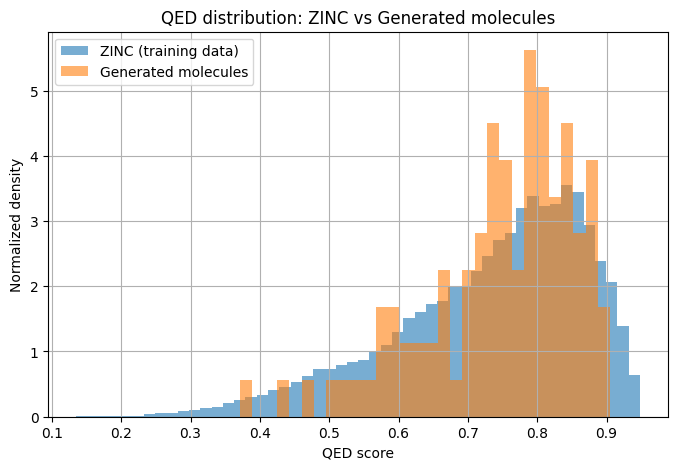

In [20]:
from rdkit.Chem import QED
import matplotlib.pyplot as plt

# ZINC 학습 데이터의 QED 점수 계산
zinc_qeds = []
for smi in tqdm(df_zinc['smiles'], desc="ZINC QED 계산 중"):
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        try:
            qed_score = QED.qed(mol)
            zinc_qeds.append(qed_score)
        except:
            pass  # QED 계산 중 오류가 날 경우 무시

# 생성된 분자들의 QED 점수 계산
generated_qeds = []
for mol in tqdm(generated_molecules, desc="생성된 분자의 QED 계산 중"):
    try:
        qed_score = QED.qed(mol)
        generated_qeds.append(qed_score)
    except:
        pass

# QED 점수 분포 시각화 (정규화된 히스토그램)
plt.figure(figsize=(8, 5))
plt.hist(zinc_qeds, bins=50, alpha=0.6, label='ZINC (training data)', density=True)
plt.hist(generated_qeds, bins=30, alpha=0.6, label='Generated molecules', density=True)
plt.xlabel("QED score")
plt.ylabel("Normalized density")
plt.title("QED distribution: ZINC vs Generated molecules")
plt.legend()
plt.grid(True)
plt.show()


생성된 분자들의 QED 분포는 학습 데이터와 겹칩니다!  
(지금 제공된 사전 학습 모델은 **충분히 학습된 최종 모델이 아닙니다**.  
제대로 학습된 생성 모델을 사용하면 두 분포 간의 겹침이 **훨씬 더 명확하게 나타납니다**)

이에 대한 자세한 사례는 이 [논문](https://www.nature.com/articles/s41467-022-30839-x)을 참고하세요.
해당 논문의 그림에서 두 분포의 겹침이 얼마나 잘 나타나는지 확인할 수 있습니다!

지금 여러분은 `Molecular Generative Models`가  
**학습 데이터에 포함된 분자의 특성을 얼마나 잘 재현하는지** 직접 검증한 셈입니다 🤩

---

이제 이 섹션의 핵심 질문에 답할 시간입니다:  
**이건 `분자 생성 모델`일까요,    
아니면 실제로는 아무것도 존재하지 않지만, 실제 있는 것처럼 흉내내는 마임일까요?**

결과를 정리해봅시다:

1. 모델은 학습 데이터에 없는 새로운 `SMILES`를 생성할 수 있습니다.  
2. 생성된 `SMILES`의 **분자적 특성**은 학습 데이터와 유사한 분포를 따릅니다.

✅ 결론: `Molecular Generative Models`는 마치 **마임**과도 같습니다.  
새로운 분자를 만들어내지만, 그 분자들은 여전히 학습 데이터와 **유사한 특성 분포** 안에 존재합니다.

---

이게 왜 유용할까요?

예를 들어, 여러분이 관심 있는 물성 범위를 갖는 분자들을 포함한 데이터셋이 있다고 합시다.  
그럴 경우, 생성 모델을 그대로 사용해도  
**해당 특성 범위 안에서 새로운 분자들을 효율적으로 만들어낼 수 있습니다.**

그런데 만약,  
> 🔍 **학습 데이터에서 벗어난 영역의 물성을 가지는 분자를 생성하고 싶다면?**

그때는 이 생성 모델 위에 **최적화 알고리즘**을 결합해  **모델이 생성하는 분자의 특성 분포 자체를 "이동(shift)"**시키는 전략을 사용할 수 있습니다.

이번 튜토리얼은 바로 그 기반이 되는 개념을 다룬 것이며, 다음 주에는 `REINVENT`를 이용한 실습을 통해 이 개념을 실제로 직접 체험해보게 됩니다.

---

이제 마지막으로, 우리가 생성한 분자들이 어떤 모습인지 한 번 살펴봅시다! 👇


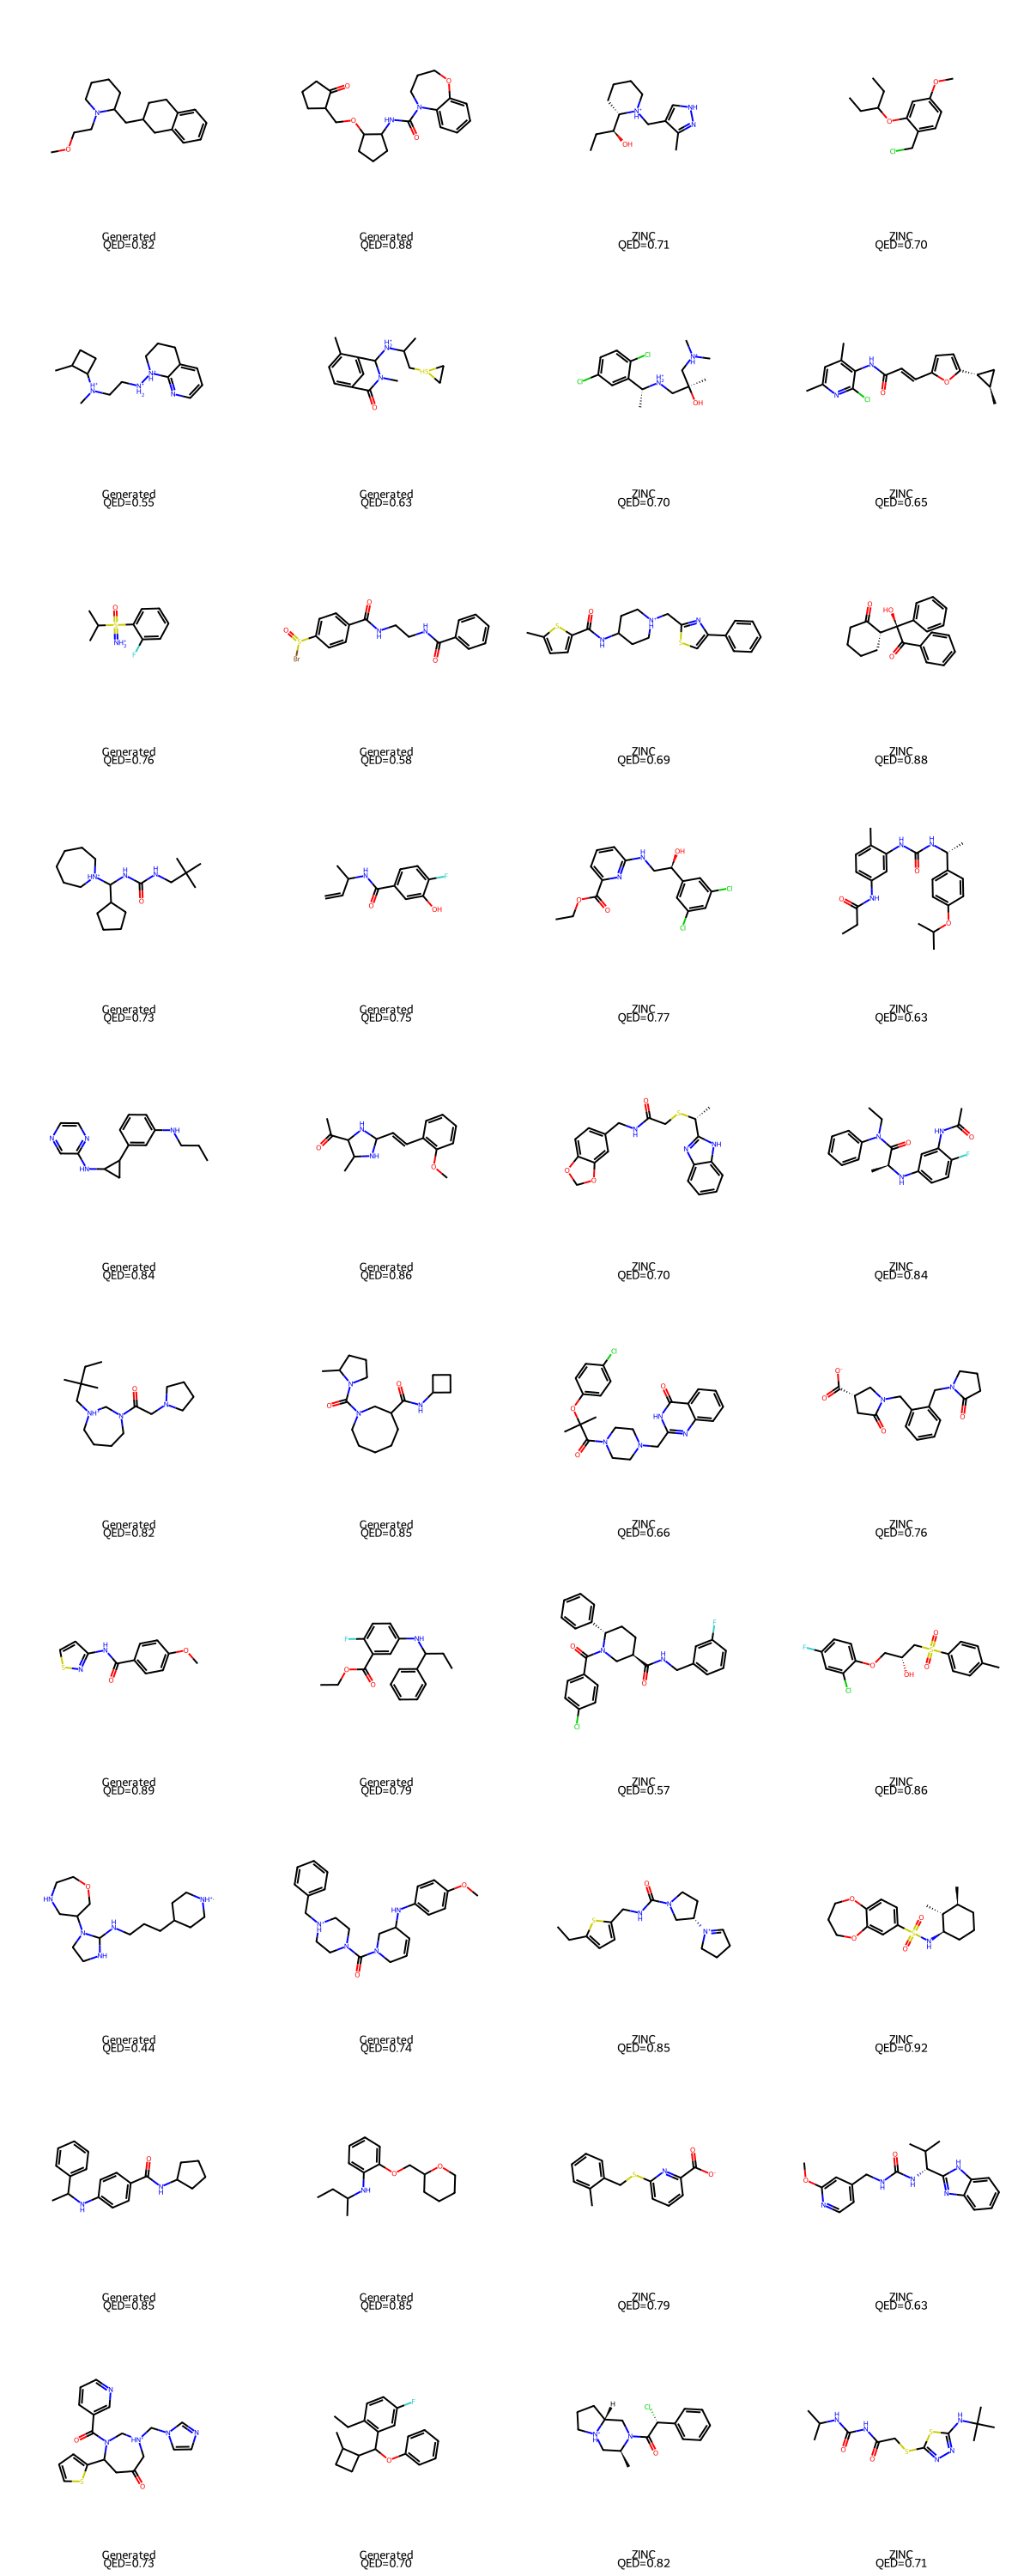

In [26]:
import random
from rdkit.Chem import Draw

# 1. 무작위 20개씩 추출
sampled_gen_mols = random.sample(generated_molecules, 20)
zinc_mols = []
for smi in random.sample(list(zinc_smiles_set), 20):
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        zinc_mols.append(mol)

# 2. QED 점수와 레전드 생성
def get_qed_legends(mols, label):
    legends = []
    for mol in mols:
        try:
            score = QED.qed(mol)
            legends.append(f"{label}\nQED={score:.2f}")
        except:
            legends.append(f"{label}\nQED=Err")
    return legends

gen_legends = get_qed_legends(sampled_gen_mols, "Generated")
zinc_legends = get_qed_legends(zinc_mols, "ZINC")

# 3. 두 개씩 묶어서 4개 단위로 interleave
grouped_mols = []
grouped_legends = []

for i in range(0, 20, 2):
    grouped_mols.extend([
        sampled_gen_mols[i], sampled_gen_mols[i+1],
        zinc_mols[i], zinc_mols[i+1]
    ])
    grouped_legends.extend([
        gen_legends[i], gen_legends[i+1],
        zinc_legends[i], zinc_legends[i+1]
    ])

# 4. 시각화 (한 줄에 4개: G G | Z Z)
Draw.MolsToGridImage(
    grouped_mols,
    molsPerRow=4,
    subImgSize=(300, 300),
    legends=grouped_legends
)

# 2. Variational Autoencoder (VAE)

이 이미지는 `ChatGPT`를 사용해 생성되었습니다. 사용한 프롬프트는 "a lego chef flattens a pancake"입니다.

<div align="middle">
<img src="https://raw.githubusercontent.com/jfjoung/AI_For_Chemistry/main/img/pancake.png" width="400"/>
</div>


---

팬케이크가 `VAE`와 무슨 관련이 있을까요?  

이번 섹션에서는 `VAE`가 무엇을 하는지에 대한 **직관적인 개요**를 소개합니다.

---

상상해봅시다. 여러분 앞에 팬케이크가 쌓여 있습니다. 어떤 팬케이크는 블루베리가 있고, 어떤 건 라즈베리가 올라가 있어요.  
이제 여러분은 가장 큰 주걱을 들어 이 팬케이크들을 **한꺼번에 납작하게 눌러버립니다** —  
그 결과는 위 이미지처럼, 원래의 팬케이크가 구분되지 않는 **하나의 거대한 납작한 팬케이크**입니다.

이제 이 거대한 팬케이크의 표면을 자세히 살펴봅니다.  
어딘가에 블루베리가 보이네요.  
여러분은 "이건 분명 블루베리 팬케이크였겠지!"라고 추측합니다.  
조금 더 돌아다니다 보니, 블루베리도 있고 라즈베리도 있는 부분이 있어요.  
원래 그런 팬케이크는 없었는데요?  
그래서 여러분은 이 조각은 **블루베리 팬케이크와 라즈베리 팬케이크가 섞인 부분일 것**이라고 추론합니다.

---

이제 이 팬케이크 비유를 기억한 채, `VAE`의 작동 방식을 도식적으로 살펴봅시다.  
아래 이미지는 [Saul Dobilas](https://towardsdatascience.com/vae-variational-autoencoders-how-to-employ-neural-networks-to-generate-new-images-bdeb216ed2c0)의 설명에서 가져온 것입니다:

<div align="middle">
<img src="https://raw.githubusercontent.com/jfjoung/AI_For_Chemistry/main/img/vae.png" width="900"/>
</div>


---

- `Encoder`: 분자를 입력받아 **저차원 벡터**로 변환하고, 이를 `가우시안 분포(Gaussian Distribution)`로 매핑합니다.  
  가우시안 분포는 `평균(mean)`과 `분산(variance)`만 알면 완전히 정의할 수 있습니다.  
- `Latent Vector`: 평균과 분산을 기반으로, 여기에 **노이즈**를 추가하여 샘플링됩니다.  
  위 그림에서는 이 노이즈도 가우시안에서 뽑습니다.
- `Decoder`: 이 `Latent Vector`를 받아 원래 입력을 **재구성(reconstruct)**하는 역할을 합니다.

---

이제 다시 팬케이크로 돌아가 봅시다 🍽️

모든 분자를 `Encoder`로 통과시켜 **저차원 연속 공간(Latent Space)** 에 위치시키는 것은  
블루베리와 라즈베리 팬케이크를 **하나의 납작한 팬케이크로 압축**하는 것과 같습니다.  

그 후 `Decoder`는 이 납작한 팬케이크의 한 지점을 보고  
"이건 블루베리 팬케이크였겠지!" 하며 원래 분자를 **재구성**하는 거죠.  
블루베리와 라즈베리가 섞인 부분이라면?  
그때는 블루베리와 라즈베리가 **섞인 새로운 분자**를 생성하게 됩니다.

바로 이 부분이 **분자 생성 모델(Molecular Generative Model)**의 핵심입니다 —  
`Latent Space`에서 다양한 위치를 샘플링함으로써  
`Decoder`는 **새로운 분자들을 생성**할 수 있습니다!

---

[`VAE` 원 논문](https://pubs.acs.org/doi/10.1021/acscentsci.7b00572)에서는  
Latent Space 상에서 분자의 물성을 예측하는 신경망을 학습시키기도 하고,  
Latent Space 안에서 어떤 시작 분자에서 출발해 **원하는 물성의 분자로 이동하는 방법**도 보여줍니다.

이번 튜토리얼에서는 세부적인 수식은 생략하고,  
`Latent Space`가 어떤 것인지 **시각적으로 직관적으로 이해**하는 데 집중해보겠습니다.
